<div align="center">
    <H1>
        <Strong>
            Analysis on Hero Compositions in Professional Overwatch
        </Strong>
    </H1>
    Chinhnam Nguyen, Jared Fleming, Ben Fleming
</div>

---

<div align="center">
    <H1>
        <Strong>
            Introduction
        </Strong>
    </H1>
</div>

Overwatch is a multiplayer team-based first-person shooter developed and published by Blizzard Entertainment and published in 2016. It skyrocketed in popularity quickly after release and is still going strong with over 5 million average players each month in 2021, and peaking as high as 7.3 million. Described as a "hero shooter", Overwatch assigns players into two teams of six, with each player selecting from a large roster of characters, known as "heroes", with unique abilities. Teams work to complete map-specific objectives within a limited period of time such as pushing a payload across the map or holding an area longer than the other team.

The meteoric rise in popularity also inspired both Blizzard and esports organizations to arrange their own teams and tournaments, resulting in the Overwatch League, which is produced and regulated by Blizzard themselves. Though based in the U.S., the league also features teams from Asia and Europe, resulting in 20 city-based teams, each with a max roster of 12 players. Due to its wide interchangeability between maps, gamemodes, and hero compositions (the heroes picked by each team), Overwatch is one of the most analyzed competitive games in the world. To help with this, Blizzard compiles and publicly releases the data collected throughout professional play during the year. All of the datasets can be accessed [here](https://overwatchleague.com/en-us/statslab "Overwatch League Stats Lab").

Here, we will be focusing on the data collected during the 2020 Overwatch League season, and will primarily intend to figure out the most optimal hero compositions for each map and gamemode. Heroes are meant to compliment and check each other as they are split into three classes: damage, support, and tank. Obviously, we would expect a team of six attack heroes to succeed in aggressing the enemy, but would also expect them to fail miserably when defending an area. This is why finding a correct and balanced composition is integral to the game, and professional play in general.

<center><img src="pictures/gallery.jpg" alt="Hero's Gallery" width="700"></center>

<div align="center">
      <Strong>
          Gallery of Overwatch Heroes
      </Strong>
</div>

---

<div align="center">
    <H1>
        <Strong>
            Exploring the Dataset
        </Strong>
    </H1>
</div>

<H3>
    <Strong>
        Libraries
    </Strong>
</H3>

We will be utilizing Python 3 along with various data science libraries: [pandas](https://pandas.pydata.org/), [numpy](https://numpy.org/), [matplotlib](https://matplotlib.org/), [seaborn](https://seaborn.pydata.org/)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn import model_selection
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import f
import warnings
warnings.filterwarnings('ignore')

The two datasets that we looked at were the players data set and the maps data set for Overwatch League 2020 regular season. The reason we chose 2020 data set is because it has a role queue system. This means there are two support heroes, two tank heroes, and two damaging heroes. In previous seasons, any of the six players could switch between any role which would cause more difficulty in analyzing and tidying our data. In the 2020 season, role queue prevents any switching to other roles which is easier to analyze. Now we will begin processing and tidying our datasets.

<H3>
    <Strong>
        Processing the Player Data
    </Strong>
</H3>

Due to its immense size (over 1.2 million rows), Blizzard released the data for 2020 in two files, one for the first half and the other for the second half. To prepare the data for processing, we will first combine the two datasets. The dataset comes in the form of two CSV files.

In [2]:
# Reading in both datasets and combine into one dataframe
players1, players2 = pd.read_csv("phs_2020/phs_2020_1.csv"), pd.read_csv("phs_2020/phs_2020_2.csv")
data = pd.concat([players1, players2])
data.head()

,start_time,esports_match_id,tournament_title,map_type,map_name,player_name,team_name,stat_name,hero_name,stat_amount
0,2/8/2020 18:13,30991,OWL 2020 Regular Season,CONTROL,Lijiang Tower,BenBest,Paris Eternal,All Damage Done,All Heroes,6674.164055
1,2/8/2020 18:13,30991,OWL 2020 Regular Season,CONTROL,Lijiang Tower,BenBest,Paris Eternal,Assists,All Heroes,11.000000
2,2/8/2020 18:13,30991,OWL 2020 Regular Season,CONTROL,Lijiang Tower,BenBest,Paris Eternal,Average Time Alive,All Heroes,60.199502
3,2/8/2020 18:13,30991,OWL 2020 Regular Season,CONTROL,Lijiang Tower,BenBest,Paris Eternal,Barrier Damage Done,All Heroes,1875.000000
4,2/8/2020 18:13,30991,OWL 2020 Regular Season,CONTROL,Lijiang Tower,BenBest,Paris Eternal,Damage Blocked,All Heroes,14640.911780


We can see that the raw dataset present us with a myriad of problems. Firstly, it includes data collected outside of the OWL 2020 Regular Season, which we will not be considering. Another issue is that `stat_name` is presented as it's own column instead of their own individual and respective columns. This will make it difficult for us to understand and view the dataset as well as accessing player statistics. We will be dropping the `start_time` column as it is irrelevant to what we are depicting, along with all rows that record the cumulative statistics for a player on all heroes (`hero_name == All Heroes`), since we are looking to compare individual hero statistics. To make things simpler, we will conglomerate a player's stats with a hero across games in a match, meaning if a player plays as a hero more than once for the same `match_id`, we will average their statistics across the games into one row. The dataset also includes a multitude of irrelevant statistics that we will need to remove, such as `Environmental Kills` i.e. number of times the player knocks an enemy off of the map. To recap, there are five things we need to do to sanitize the data:
1. Drop all non OWL 2020 Regular Season rows
2. Pivot the table to turn stat_name into columns with stat_amount as values
3. Drop `start_time`
4. Drop all `hero_name == All Heroes` rows
5. Drop all irrelevant statistics

<H3>
    <Strong>
        Tidying the Player Dataset
    </Strong>
</H3>

First, lets drop all irrelevant columns and rows and rearrange the columns into a more readable format.

In [3]:
# Drop irrelevant columns and rows
data.drop(['start_time'], axis=1)
data.drop(data.index[data['tournament_title'] != 'OWL 2020 Regular Season'], inplace=True)
data.drop(['tournament_title'], axis = 1, inplace = True)
data = data.reindex(columns = ['esports_match_id', 'map_type', 'map_name', 'player_name', 'team_name', 'hero_name', 'stat_name', 'stat_amount'])
data = data[data["hero_name"] != "All Heroes"]
stats = ['Hero Damage Done', 'Assists', 'Barrier Damage Done', 'Deaths', 'Eliminations', 'Objective Kills', 'Objective Time', 'Ultimates Earned - Fractional', 'Final Blows', \
     'Damage Blocked', 'Healing Done', 'All Damage Done']
data = data.loc[data['stat_name'].isin(stats)]
data['stat_amount'] = data['stat_amount'].round(decimals = 2)
data.head()

,esports_match_id,map_type,map_name,player_name,team_name,hero_name,stat_name,stat_amount
22,30991,CONTROL,Lijiang Tower,BenBest,Paris Eternal,Reinhardt,All Damage Done,6674.16
23,30991,CONTROL,Lijiang Tower,BenBest,Paris Eternal,Reinhardt,Assists,11.00
25,30991,CONTROL,Lijiang Tower,BenBest,Paris Eternal,Reinhardt,Barrier Damage Done,1875.00
31,30991,CONTROL,Lijiang Tower,BenBest,Paris Eternal,Reinhardt,Damage Blocked,14640.91
33,30991,CONTROL,Lijiang Tower,BenBest,Paris Eternal,Reinhardt,Deaths,5.00


The dataframe already looks much better but we're not done yet. Now we can pivot the table to turn `stat_name` into columns and `stat_amount` into rows.

In [4]:
# Tidy dataset to elongate stat_name column into rows and insert respective stat_amount values
data = data[['stat_name', 'stat_amount', 'player_name','esports_match_id','hero_name','map_name', 'team_name']].copy().reset_index()
data = data.pivot_table(values='stat_amount', index=[data['esports_match_id'],data['team_name'], data['player_name'], data['map_name'], data['hero_name']], columns='stat_name', aggfunc='sum')
data = data.fillna(0).reset_index()
data.rename(columns = {'Ultimates Earned - Fractional':'Ultimates Earned', 'esports_match_id':'match_id'}, inplace = True)
data['map_name'].replace({'King\'s Row': 'Kings Row'}, inplace = True)
data.head()

stat_name,match_id,team_name,player_name,map_name,hero_name,All Damage Done,Assists,Barrier Damage Done,Damage Blocked,Deaths,Eliminations,Final Blows,Healing Done,Hero Damage Done,Objective Kills,Objective Time,Ultimates Earned
0,30991,Paris Eternal,BenBest,Eichenwalde,Reinhardt,14495.63,10.0,5517.72,32655.81,9.0,19.0,9.0,0.00,8976.92,10.0,295.96,7.97
1,30991,Paris Eternal,BenBest,Havana,Reinhardt,9921.49,6.0,3075.00,21137.18,11.0,10.0,4.0,0.00,6837.43,3.0,148.89,5.15
2,30991,Paris Eternal,BenBest,Horizon Lunar Colony,Reinhardt,12362.02,13.0,3236.46,19394.67,10.0,21.0,8.0,0.00,8945.56,8.0,114.43,6.52
3,30991,Paris Eternal,BenBest,Lijiang Tower,Reinhardt,6674.16,11.0,1875.00,14640.91,5.0,13.0,2.0,0.00,4798.16,9.0,65.05,3.71
4,30991,Paris Eternal,FDGod,Eichenwalde,Lúcio,12012.14,14.0,5175.00,0.00,9.0,18.0,2.0,9229.73,6836.14,9.0,167.42,7.03


Here, we can see that the finalized dataset we will be analyzing has five objective columns and twelve stat columns. 
<Strong>Objective Columns:</Strong>
* `match_id` - The number referencing the matches in which the player earned the stats. A series of matches will have the same match_id.
* `team_name` - Name of the team of the player.
* `player_name` - In-game name of the player.
* `map_name` - Names of the maps on which the games were played.
* `hero_name` - Names of the heroes that the player played as.

<Strong>Stat Columns:</Strong>
* `All Damage Done` - Total damage done by the player in the match.
* `Assists` - Enemy deaths that the player participated in but did not achieve the final blow.
* `Barrier Damage Done` - Damage done by player only to enemy barriers.
* `Damage Blocked` - Damage blocked by the player's barriers (will only apply to barrier heroes).
* `Deaths` - Total death count of the player.
* `Eliminations` - Total number of enemy deaths that the player participated in.
* `Final Blows` - Enemy deaths in which the player achieved the final blow.
* `Healing Done` - Total personal and team health points healed by the player (will only apply to healing heroes).
* `Hero Damage Done` - Damage done only to enemy heroes.
* `Objective Kills` - Eliminations made by the player where the enemy was either at the objective point, or the player was defending the objective point.
* `Objective Time` - Time spent by the player either defending or attacking the objective point.
* `Ultimates Earned` - Total ultimate abilities earned by the player.

Now, we can easily transform the dataframe and access stat values as necessary!

<center><img src="pictures/pros.jpeg" alt="Hero's Gallery" width="600"></center>

<div align="center">
      <Strong>
          Overwatch League's Finest
      </Strong>
</div>

<H3>
    <Strong>
        Tidying the Map Dataset
    </Strong>
</H3>

Blizzard also released data that had every Overwatch League played matches from 2018 to 2021. We are only going to look at the professional Overwatch League 2020 regular season matches.

In [5]:
maps = pd.read_csv("match_map_stats.csv")
maps.head()

,round_start_time,round_end_time,stage,match_id,game_number,match_winner,map_winner,map_loser,map_name,map_round,...,team_one_name,team_two_name,attacker_payload_distance,defender_payload_distance,attacker_time_banked,defender_time_banked,attacker_control_perecent,defender_control_perecent,attacker_round_end_score,defender_round_end_score
0,2018-01-11 00:12:07,2018-01-11 00:20:07,Overwatch League - Stage 1,10223,1,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Dorado,1,...,Los Angeles Valiant,San Francisco Shock,75.615051,0.000000,0.000000,240.000000,NaN,NaN,2,0
1,2018-01-11 00:22:05,2018-01-11 00:27:59,Overwatch League - Stage 1,10223,1,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Dorado,2,...,Los Angeles Valiant,San Francisco Shock,75.649597,75.615051,125.750572,0.000000,NaN,NaN,3,2
2,2018-01-11 00:34:39,2018-01-11 00:38:29,Overwatch League - Stage 1,10223,2,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Temple of Anubis,1,...,Los Angeles Valiant,San Francisco Shock,0.000000,0.000000,250.492004,240.000000,NaN,NaN,2,0
3,2018-01-11 00:40:27,2018-01-11 00:44:41,Overwatch League - Stage 1,10223,2,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Temple of Anubis,2,...,Los Angeles Valiant,San Francisco Shock,0.000000,0.000000,225.789032,250.492004,NaN,NaN,2,2
4,2018-01-11 00:46:09,2018-01-11 00:49:48,Overwatch League - Stage 1,10223,2,Los Angeles Valiant,Los Angeles Valiant,San Francisco Shock,Temple of Anubis,3,...,Los Angeles Valiant,San Francisco Shock,0.000000,0.000000,36.396057,250.492004,NaN,NaN,4,2


In our maps data set we have 25 columns, and they most of them are not important but the important ones are:
 - ```match_id``` - The number referencing the matches in which the teams competed. A series of matches will have the same match_id.
 - ```team_one``` and team_two - Two team names from the map played
 - ```map_winner``` - Winner of the map
 - ```map_name``` - Names of the maps on which the games were played.
 - ```game_number``` - The number of the map played in the match
 - ```match_winner``` - Winner of the entire match of maps

We will remove the unncessary columns and only keep the match_id, the two team names, map name, map winner, game number, and the match winner. The only issue is each Overwatch game has multiple rounds of each game, so the data has rows for each teams attack and defense or overtime. These excessive rows are not needed because all of the rows display the same team names, map winner, and match winner so we can drop duplicate rows.

In [6]:
maps['map_name'].replace({'King\'s Row': 'Kings Row'}, inplace = True)
cleaned_maps = pd.DataFrame()
# Only takes match id of 2020 season games which is between match ids of 30991 and 36231 from the player data table
maps.query("`match_id` >= 30991", inplace = True)
maps.query("`match_id` <= 36231", inplace = True)
cleaned_maps = pd.DataFrame(maps, columns = ['match_id', 'team_one_name', 'team_two_name', 'map_winner', 'map_name', 'game_number', 'match_winner'])
# Only took necessary columns
cleaned_maps.rename(columns = {'team_one_name': 'team_one', 'team_two_name': 'team_two'}, inplace = True)
cleaned_maps.drop_duplicates(inplace = True)
cleaned_maps.head()

,match_id,team_one,team_two,map_winner,map_name,game_number,match_winner
6246,30991,Toronto Defiant,Paris Eternal,Paris Eternal,Lijiang Tower,1,Toronto Defiant
6248,30991,Paris Eternal,Toronto Defiant,Toronto Defiant,Eichenwalde,2,Toronto Defiant
6252,30991,Paris Eternal,Toronto Defiant,Toronto Defiant,Horizon Lunar Colony,3,Toronto Defiant
6255,30991,Paris Eternal,Toronto Defiant,Toronto Defiant,Havana,4,Toronto Defiant
6257,30992,London Spitfire,New York Excelsior,London Spitfire,Lijiang Tower,1,New York Excelsior


We can see that there are not many visibile errors except team_one and team_two sometimes switch which name comes first in team_one and team_two. So here we fix that by putting them in alphabetical order.

In [7]:
new_frame = pd.DataFrame(columns = cleaned_maps.columns)
for index, row in cleaned_maps.iterrows():
    if row['team_two'] < row['team_one']:
        new_frame.loc[index] = [row['match_id'], row['team_two'], row['team_one'], row['map_winner'], row['map_name'], row['game_number'], row['match_winner']]
    else:
        new_frame.loc[index] = [row['match_id'], row['team_one'], row['team_two'], row['map_winner'], row['map_name'], row['game_number'], row['match_winner']]
cleaned_maps = new_frame
cleaned_maps.head()      

,match_id,team_one,team_two,map_winner,map_name,game_number,match_winner
6246,30991,Paris Eternal,Toronto Defiant,Paris Eternal,Lijiang Tower,1,Toronto Defiant
6248,30991,Paris Eternal,Toronto Defiant,Toronto Defiant,Eichenwalde,2,Toronto Defiant
6252,30991,Paris Eternal,Toronto Defiant,Toronto Defiant,Horizon Lunar Colony,3,Toronto Defiant
6255,30991,Paris Eternal,Toronto Defiant,Toronto Defiant,Havana,4,Toronto Defiant
6257,30992,London Spitfire,New York Excelsior,London Spitfire,Lijiang Tower,1,New York Excelsior


Now that we have our map data tidy we can perform analysis on the two data sets we have created.

<center><img src="pictures/Eichenwalde.jpg" alt="Hero's Gallery" width="600"></center>

<div align="center">
      <Strong>
          In Game Map: Eichenwalde
      </Strong>
</div>

---

<div align="center">
    <H1>
        <Strong>
            Exploratory Data Analysis
        </Strong>
    </H1>
</div>

<H3>
    <Strong>
        Pick Rate per Hero
    </Strong>
</H3>

One way of measuring how "good" a hero is in Overwatch is looking at the pick rate of each hero on different maps in Overwatch League. We wanted to see how much these numbers vary for different heroes, and we could then measure if a professional teams' decision to pick certain heroes is a good decision.

In [8]:
map_list = data['map_name'].unique()
hero_list = data['hero_name'].unique()
# Pick rate is going to be a dictionary whose keys are the map names, and the values are dictionaries whose keys
# are the hero names and the values are the number of picks for each hero on that map.
pick_rate = {}
for name in map_list:
    # Initialized dictionary of map pick rate per hero 
    map_rate = {}
    for val in hero_list:
        map_rate[val] = 0
    for index, row in data.iterrows():
        #row[3] is map, and row[4] is hero
        if row[3] == name:
            # Increments the pick value of the hero if it appears in the row
            map_rate[row[4]] = map_rate[row[4]] + 1
    # assigns the dictionary to its map key
    pick_rate[name] = map_rate
pick_frame = pd.DataFrame()

# Converts the double dictionary structure into a dataframe
for name_map in map_list:
    for name_hero in hero_list:
        temp_dict = {'map_name': name_map, 'hero_name': name_hero, 'pick': pick_rate.get(name_map, 0).get(name_hero, 0)}
        pick_frame = pick_frame.append(temp_dict, ignore_index = True)
pick_frame.head()

,map_name,hero_name,pick
0,Eichenwalde,Reinhardt,34.0
1,Eichenwalde,Lúcio,59.0
2,Eichenwalde,Baptiste,54.0
3,Eichenwalde,Moira,35.0
4,Eichenwalde,Ana,45.0


Now we will plot the pick rate for each hero on each map on a heat map

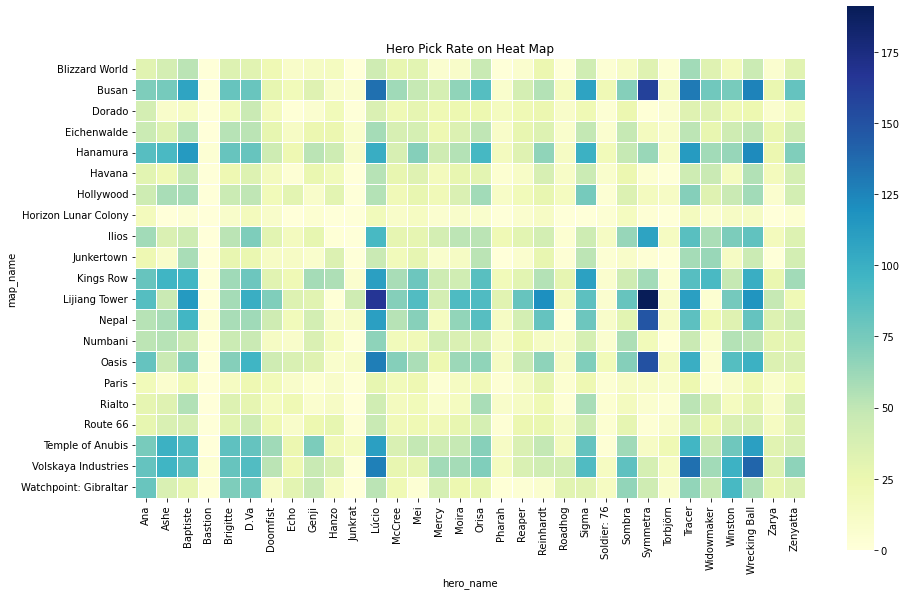

In [9]:
new_data = pick_frame.pivot(index='map_name', columns='hero_name', values='pick')
figure, axis = plt.subplots(figsize=(15,10))
plt.title('Hero Pick Rate on Heat Map')
# cmap will change the color to better support our analysis
sns.heatmap(new_data,cmap = "YlGnBu", ax=axis, square=True, linewidths=.6)
plt.show()

As we look at this heat map we see some very obvious trends. The darkest square or highest pick rate is clearly Symmetra on Lijiang Tower which makes sense. In the 2020 regular season of Overwatch, the most frequent strategy for teams was to use Symmetra's teleport to get to the control site much faster. Another common hero picked was Lucio on maps like Lijiang Tower, Nepal, and Ilios because Lucio has an ability to push back enemies. This is very useful on maps with holes or openings to be pushed to their death such as Lijiang Tower, Nepal, and Ilios. We can see other strategies/patterns in this heat map as we look at the least played heroes on maps in Overwatch League. These heroes include Bastion, Junkrat, Pharah, and Torbjorn who have seen very little pick rates as they are the most situational characters in the game. In high ranked gameplay, characters that can be easily countered such as these four are rarely seen on the competitive stage.

Another useful insight is to look at the dominant heroes in their subclasses. As we can see in terms of healers, Baptiste and Lucio have the highest pick rates across maps. Lucio, since the creation of Overwatch, has been viewed as the most consistently viable hero on a large number of maps. In terms of damagers (dps), Tracer and Ashe have the highest pick rates across maps, and for tanks, Wrecking Ball, Orisa, and D.Va have the highest pick rates. Additionally, an interesting analysis can be made on Symmetra's pick rates. While she appears to have an incredibly high pick rate, she really only has a very high pick rate on 4-5 maps and an extremely low pick rate on at least 8 maps. This shows how good Symmetra is but also how situational she can be on maps such as Busan, Oasis, and Nepal.

<H3>
    <Strong>
        Linear Regression for Wins
    </Strong>
</H3>

We noticed that there are a lot of statistics to consider for each hero played as well as the "class" these heroes fall into. The three classes as mentioned before are Supports (Healer), Damager (DPS), and Tank. We wanted to see which stats are statistically significant to a hero's team winning the map. We looked at the 11 basic stats for each hero's class:
 - ```Assists```
 - ```Deaths```
 - ```Eliminations```
 - ```Hero Damage Done```
 - ```Ultimates Earned```
 - ```Objective Kills```
 - ```Objective Time```
 - ```Final Blows```
 - ```Healing Done``` - Primarily used for Healers
 - ```Barrier Damage Done``` - Primarily used for Tanks and Damagers
 - ```Damage Blocked``` - Primarily used for Tanks
 

In [10]:
merged_df = pd.merge(data, cleaned_maps, how = 'left', left_on = ['match_id', 'map_name'], right_on = ['match_id', 'map_name'])
def win_calc (row):
    # 1 represents the team in that row won the map
    if (row['team_name'] == row['map_winner']):
        return 1
    return 0
merged_df['winner'] = merged_df.apply(lambda row: win_calc(row), axis=1)
merged_df.drop(['team_one', 'team_two', 'game_number', 'match_winner', 'map_winner'], axis = 1, inplace = True)
merged_df.head()

,match_id,team_name,player_name,map_name,hero_name,All Damage Done,Assists,Barrier Damage Done,Damage Blocked,Deaths,Eliminations,Final Blows,Healing Done,Hero Damage Done,Objective Kills,Objective Time,Ultimates Earned,winner
0,30991,Paris Eternal,BenBest,Eichenwalde,Reinhardt,14495.63,10.0,5517.72,32655.81,9.0,19.0,9.0,0.00,8976.92,10.0,295.96,7.97,0
1,30991,Paris Eternal,BenBest,Havana,Reinhardt,9921.49,6.0,3075.00,21137.18,11.0,10.0,4.0,0.00,6837.43,3.0,148.89,5.15,0
2,30991,Paris Eternal,BenBest,Horizon Lunar Colony,Reinhardt,12362.02,13.0,3236.46,19394.67,10.0,21.0,8.0,0.00,8945.56,8.0,114.43,6.52,0
3,30991,Paris Eternal,BenBest,Lijiang Tower,Reinhardt,6674.16,11.0,1875.00,14640.91,5.0,13.0,2.0,0.00,4798.16,9.0,65.05,3.71,1
4,30991,Paris Eternal,FDGod,Eichenwalde,Lúcio,12012.14,14.0,5175.00,0.00,9.0,18.0,2.0,9229.73,6836.14,9.0,167.42,7.03,0


First we have to add a wins column that will act as the dependent variable in our regression. I had to merge the map data with our player data to add a winner column.

In [11]:
# Split the heroes by their class
damagers = ['Ashe', 'Bastion', 'McCree', 'Echo', 'Genji', 'Hanzo', 'Junkrat', 'Mei', 'Pharah', 'Reaper', 'Soldier: 76', 'Sombra', 'Symmetra', 'Torbjörn', 'Tracer', 'Widowmaker']
tanks = ['D.Va', 'Doomfist', 'Orisa', 'Reinhardt', 'Roadhog', 'Sigma', 'Winston', 'Wrecking Ball', 'Zarya']
supports = ['Ana', 'Baptiste', 'Brigitte', 'Lúcio', 'Mercy', 'Moira', 'Zenyatta']
classes = ['Damage', 'Support', 'Tank']
res_array = []
# For loop runs through the 3 classes of heroes
for curr_class in classes:
    # Take rows of only heroes of the current class
    if (curr_class == 'Damage'):
        curr_table = merged_df.loc[merged_df['hero_name'].isin(damagers)].copy()
        formula_class = 'winner ~ Assists + Deaths + Eliminations + Hero_Damage_Done + Ultimates_Earned + Objective_Kills + Objective_Time + Final_Blows + Barrier_Damage_Done'
    elif (curr_class == 'Support'):
        curr_table = merged_df.loc[merged_df['hero_name'].isin(supports)].copy()
        formula_class = 'winner ~ Assists + Deaths + Eliminations + Hero_Damage_Done + Ultimates_Earned + Objective_Kills + Objective_Time + Final_Blows + Healing_Done'
    else:
        curr_table = merged_df.loc[merged_df['hero_name'].isin(tanks)].copy()
        formula_class = 'winner ~ Assists + Deaths + Eliminations + Hero_Damage_Done + Ultimates_Earned + Objective_Kills + Objective_Time + Final_Blows + Barrier_Damage_Done + Damage_Blocked'
    # Different formuals depending on your roles
    curr_table.columns = curr_table.columns.str.replace(' ','_')
    # The spacing causes a syntax error so I replaced with underscore
    eval_table = curr_table.drop(['match_id', 'team_name', 'player_name', 'map_name', 'hero_name'], axis = 1)
    # Dropped non-integer columns not needed for the model
    x = eval_table.drop(['winner'], axis = 1)
    y = eval_table['winner']
    # x is the dependent variables and y is the independent
    x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size = 0.25)
    # Split into test and training set
    x_train['winner'] = y_train
    mod = smf.ols(formula = formula_class, data = x_train)
    res = mod.fit()
    res_array.append(res)
    # Array that has healer's fit in index 0, DPS's fit in index 1, and Tank's fit in index 2 

The variables that I am testing, as mentioned above, were fit using ```smf.ols```. I split the data into training and test sets for x and y and used the model selection library for the splitting. All three classes had similar variables being looked into. The exception was healers and DPS not having damage blocked because they do not have a barrier, and the other exception was support's (healer) not having barrier damage. Healer's do incredibly little damage to barrier so it is not a fair stat to look at for their class. Now we will look at the which variables impacted whether a team wins their map.

<H3>
    <Strong>
        Regression Analysis
    </Strong>
</H3>

### Damagers (DPS)

In [12]:
# Damage regression fit
print('Coef: \n{}'.format(res_array[0].params.to_string()))
print('\nP Values: \n{}'.format(res_array[0].pvalues.to_string()))

Coef: 
Intercept              0.464972
Assists                0.015533
Deaths                -0.076186
Eliminations           0.015918
Hero_Damage_Done      -0.000008
Ultimates_Earned      -0.009610
Objective_Kills        0.004005
Objective_Time        -0.000871
Final_Blows            0.017037
Barrier_Damage_Done    0.000002

P Values: 
Intercept               0.000000e+00
Assists                 7.628233e-01
Deaths                 7.175190e-150
Eliminations            7.572546e-01
Hero_Damage_Done        2.032382e-02
Ultimates_Earned        6.394055e-02
Objective_Kills         1.430051e-01
Objective_Time          6.299594e-04
Final_Blows             7.409020e-01
Barrier_Damage_Done     4.789539e-01


The first thing we look at after a linear regression is whether the independent variables are significant to the dependent variable, and in our case for DPS role all of the variables we are looking at have a p-value of less then 0.05 which means our variables are significant to the model. This ia a good first step but the next analysis is to see how they affect a team's ability to win. We notice that ```Deaths```, ```Hero Damage Done```, ```Ultimates Earned```, ```Objective Time```, and ```Barrier Damage Done``` all have a negative correlation to a team winning. While most these correlations have a low mangitude, ```Deaths``` makes the most sense as the more you die the less contributions you have to the team. The next few are tricky to understand but there is logic behind all of them. For ```Objective Time```, you wouldn't want you're main source of damage to be sitting on the objective instead of going out to get kills so a negative correlation makes intuitive sense. For ```Barrier Damage Done```, Overwatch League is incredibly fast paced so wasting a large portion of time breaking the enemies shield is not ideal. Usually between off angles and other teammate's contriubtion, a DPS hero will not solely focus on breaking the barrier so this makes sense to have a slight negative correlation. Now ```Hero Damage Done``` is more difficult to interpret as DPS's role is to put our damage; however, this isn't technically correct. The job of a DPS hero is to get eliminations and pick off the lower health enemies such as their support and DPS hero's. The reason there is a slight negative correlation is it is not beneficial for these heroes to focus on outputing the most amount of damage which would be continously fighting the enemy tanks. Tanks have the largest health and usually a form of a regenerative shield. You're team will lose if you focus too much of you're time and resources on fighting high health enemies such as Wrecking Ball or Winston. The enemy team will pick you apart if you do not have perfect decision making. We know more elimination participation is what our model predicts is best to win a game. We can see this with the positive correlation to ```Assists```, ```Eliminations```, ```Objective Kills```, and ```"Final Blows```. These are all ```Elimination``` stats.

<center><img src="pictures/Lucio.jpg" alt="Hero's Gallery" width="600"></center>

<div align="center">
      <Strong>
          In Game Hero: Lucio
      </Strong>
</div>

### Supports (Healers)

In [13]:
# Support regression fit
print('Coef: \n{}'.format(res_array[1].params.to_string()))
print('\nP Values: \n{}'.format(res_array[1].pvalues.to_string()))

Coef: 
Intercept           0.457665
Assists             0.000499
Deaths             -0.081614
Eliminations        0.029742
Hero_Damage_Done   -0.000067
Ultimates_Earned    0.104139
Objective_Kills    -0.003536
Objective_Time      0.000535
Final_Blows         0.024549
Healing_Done       -0.000033

P Values: 
Intercept            0.000000e+00
Assists              9.774418e-01
Deaths              6.244283e-155
Eliminations         8.797997e-02
Hero_Damage_Done     3.815310e-35
Ultimates_Earned     8.141778e-29
Objective_Kills      2.536428e-01
Objective_Time       3.776215e-03
Final_Blows          1.620958e-01
Healing_Done         9.078595e-18


When we look at the Support (Healer) role, we see different correlation trends to the DPS role as shown above. We have more obvious trends here because as a healer, they prioritize aiding other players. The negative correlated variables to winning include ```Assists```, ```Deaths```, ```Hero Damage Done```, ```Objective Kills```, ```Healing Done```. ```Deaths``` makes the most sense on why it is negatively correlated as if you are dead, you cannot aid the team. ```Objective Kills``` also makes sense why it would be negatively correlated because you're goal as a healer is not to be focusing on objective fights. If any eliminations occur, they usually occur away from the objective on enemy DPS or healers who are not on the objective. ```Hero Damage Done``` and ```Healing Done``` both have very small negative correlations, and the ```Healing Done``` stat is confusing as to why it is negative. This does make intuitive sense because healers can do the most healing on tanks who have the most health and this will make their healing stat sky rocket. However, they are not helping the team if they are just focusing solely on healing the tanks. Smaller aid to DPS and you're other healer is important and could cause this correlation to be negative. When we look at the positive correlation we again see a focus on ```Eliminations``` based stats with ```Eliminations```, ```Ultimates Earned```, ```Objective Time```, ```Final Blows```. This logically makes sense due to area healing healers who's job is usually to stay on the objective and run away if the enemy focuses them. The ```Eliminations``` and ```Ultimates Earned``` is a very important statistic because if healers can focus on supporting their teammates as well as getting kills then they will give the best efficiency for their team. ```Ultimates Earned``` is the most important because support ultimates are team winning fights usually so if you can build them up faster then you are contributing more to the team.

### Tanks

In [14]:
# Tank regression fit
print('Coef: \n{}'.format(res_array[2].params.to_string()))
print('\nP Values: \n{}'.format(res_array[2].pvalues.to_string()))

Coef: 
Intercept              0.443723
Assists               -0.018015
Deaths                -0.075696
Eliminations           0.044497
Hero_Damage_Done      -0.000001
Ultimates_Earned      -0.011310
Objective_Kills        0.007412
Objective_Time        -0.000218
Final_Blows           -0.011570
Barrier_Damage_Done   -0.000013
Damage_Blocked         0.000005

P Values: 
Intercept               0.000000e+00
Assists                 3.737304e-01
Deaths                 6.122514e-164
Eliminations            2.730805e-02
Hero_Damage_Done        7.730735e-01
Ultimates_Earned        1.585638e-02
Objective_Kills         1.564197e-03
Objective_Time          1.249910e-01
Final_Blows             5.679724e-01
Barrier_Damage_Done     4.385149e-07
Damage_Blocked          4.976096e-05


Tanks' variable correlation to predicting a win makes the most sense out of the three roles. There only ```Eliminations```, ```Objective Kills```, and ```Damage Blocked``` that have a positive correlations. This lines up with the role of tanks whose job is to fight on the objectives and defend their teammates. They should be blocking damage, killing enemies that are close to them, and fighthing near the objective. All of the other parameters have a negative correlation and this includes ```Assists```, ```Deaths```, ```Hero Damage Done```, ```Ultimates Earned```, ```Objective Time```, ```Final Blows```, and ```Barrier Damage Done```. ```Assists```, ```Deaths```, and ```Hero Damage Done``` makes sense because these are not constructive to protecting you're teammates. ```Ultimates Earned``` is also an area that most tank players tend to over use. While they are considered "big" abilities, they are also prone to be overused and used incorrectly. Our model is showing that staying with the team and focusing on normal abilities is better than farming/building your ultimate. ```Barrier Damage Done``` is also a stat that tanks cannot affect that much because very view have shield break abilities. For all of these parameters, we must have remember that these correlations are very small in magnitude, so there interpretation must be taken with a grain of salt. For example, the hero damage stat in DPS heroes most likely should be positive; however, the magnitude is incredibly small. Also, the healer healing amount should be positive but again the magnitude is very small so with more data it could/most likely become positive.

### F Test Analysis

In [15]:
# F tests for all three classes
for i in range (0, 3):
    print('{}:'.format(classes[i]))
    # Runs f test
    ftest = res_array[i].f_test(np.identity(len(res_array[i].params)))
    print('F Statistic: {}'.format(f.ppf(0.95, ftest.df_num, ftest.df_denom)))
    print('F Value: {}'.format(ftest.fvalue[0][0]))
    print('P Value: {}'.format(ftest.pvalue))

Damage:
F Statistic: 1.8320389538167214
F Value: 1000.663701876063
P Value: 0.0
Support:
F Statistic: 1.8324395987107618
F Value: 794.0840969024106
P Value: 0.0
Tank:
F Statistic: 1.790195096712409
F Value: 863.5779137741291
P Value: 0.0


As we can see from our f test all of our F Values are greater than our F Statistics and our P Values are all less than 0.05, our significance level. This means we have created a significant model with relating a predicted win to our paramaters for each subclass of the heroes. 

<H3>
    <Strong>
        Determining Best Heroes per Class
    </Strong>
</H3>

In order to determine the best heroes for each class, one could spend a lot of time manually testing and collecting DPS (damage per second), healing ability, movement capability, and a horde of other statistics, and then compare them to one another, then do another round of in-game testing to take into account player and map variability, etc. However, as poor college students trying to make it through finals, we do not have this time. We can, however, have other people test out the heroes, find their weaknesses and strengths, and determine their overall playability. Professional players are the best of the best. They practice everyday and are constantly limit-testing heroes to their fullest capability. As a result, we can look to them to tell us who the best heroes are.

<H3>
    <Strong>
        Which heroes do the best players play?
    </Strong>
</H3>

In order to determine which heroes are most frequently used by professional players, we will first split the available hero gallery into their respective classes. We will then determine the <b>Efficiency</b> of each player compared to other players playing in the same class by applying an equation that takes into account all of the statistics available in the dataframe. Because different classes are meant to emphasize different statistics, we will be applying different efficiency equations for each class. We will then graph the efficiencies of each player for each class in order to compare them to their teammates as well as their oponents.

In [16]:
# Ignore map and average stats and prepare to plot efficiencies of each team per class
average_table = data.drop('map_name', axis=1, inplace=False)
average_table = average_table.groupby(['match_id', 'team_name', 'player_name', 'hero_name']).mean().reset_index()
teams = average_table['team_name'].unique()

<H3>
    <Strong>
        Efficiency Equations for each Class:
    </Strong>
</H3>

<b>Damage</b> heroes are responsible for seeking out, engaging, and defeating the enemy using their varied tools and abilities. It is up to the damage heroes to secure kills. Because of this, we will add more weight to `Assists`, `Barrier Damage Done`, `Eliminations`, `All Damage Done`, `Final Blows`, and `Objective Kills`.
* Damage Efficiency = 2(Ass.) + 2(Barrier Dam.) - 1.5(Deaths) + 2.5(Eliminations) + 2(All Dam.) + 2(Final Blows) + (Healing Done) + 2(Obj Kills) + (Obj Time) + 1.5(Ults Earned)

<b>Support</b> heroes empower their allies by healing them, boosting their damage, and providing vital utility. They act as the backbone of the team's survival. For this reason we will add more weight to `Assists`, `Healing Done`, `Objective Kills`, `Objective Time`, and `Ultimates Earned`, and penalize stronger for `Deaths`.
* Support Efficiency = 2(Ass.) + 1.5(Barrier Dam.) - 2(Deaths) + 1.5(Eliminations) + (All Dam.) + (Final Blows) + 2.5(Healing Done) + 1.5(Obj Kills) + (Obj Time) + 1.5(Ults Earned)

<b>Tanks</b> specialize in protecting allies, disrupting enemies, and occupying the front line. They have high survivability and abilities that protect themselves and others with shields and crowd control. As a result, we will add more weight to `Assists`, `Damaged Blocked`, `Eliminations`, `All Damage Done`, `Objective Kills`, `Objective Time`, and penalize much harder for `Deaths`.
* Tank Efficiency = 1.5(Ass.) + (Barrier Dam.) + 1.5(Dam. Blocked) - 3(Deaths) + 2(Eliminations) + 1.5(All Dam.) + (Final Blows) + (Healing Done) + 1.5(Obj Kills) + 2(Obj Time) + (Ults Earned)

Now that we have determined our equations for each class, we can now calculate the effiencies of each player and then graph the results. This will show us which players are the best at each class, and from there we can find the most frequently used heroes chosen by the most efficient players.


Top 3 most efficient Damage players: 
Saucy (Atlanta Reign): 45351.24
zYKK (Toronto Defiant): 45013.08
Agilities (Toronto Defiant): 42955.2

Top 3 most efficient Support players: 
Haksal (New York Excelsior): 50429.34
Boombox (Philadelphia Fusion): 50166.52
ir1s (Atlanta Reign): 49762.16

Top 3 most efficient Tank players: 
LhCloudy (Los Angeles Gladiators): 47879.26
GiG (Los Angeles Valiant): 46805.45
Trill (Dallas Fuel): 45493.45


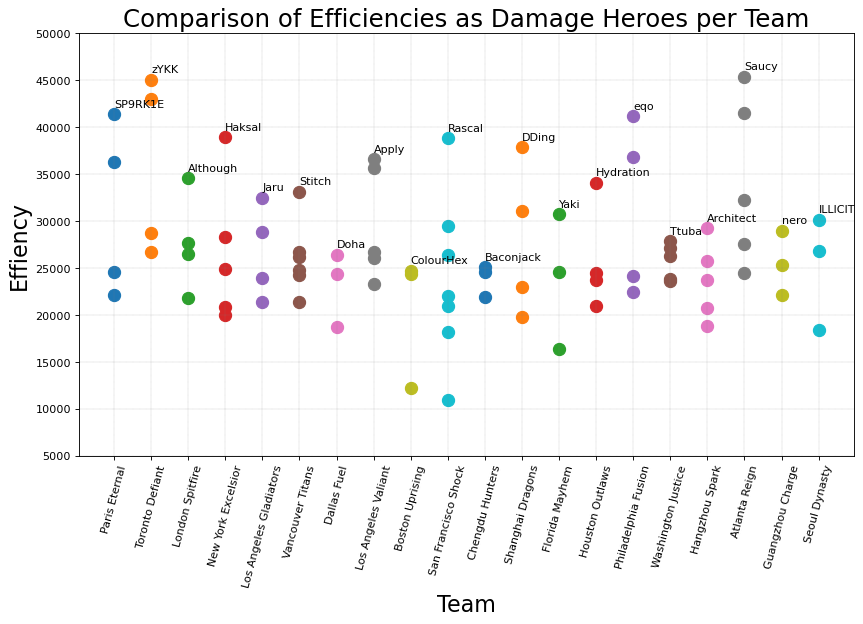

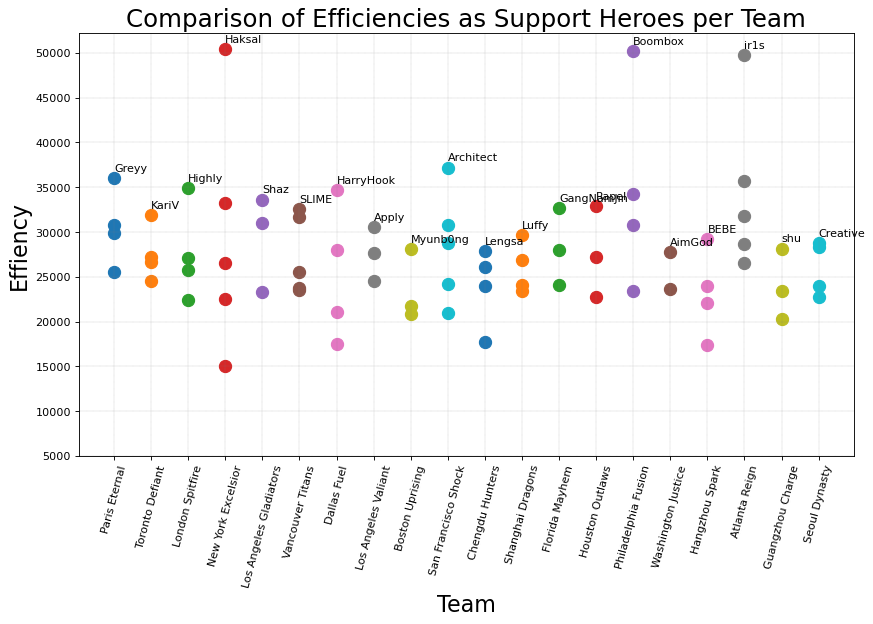

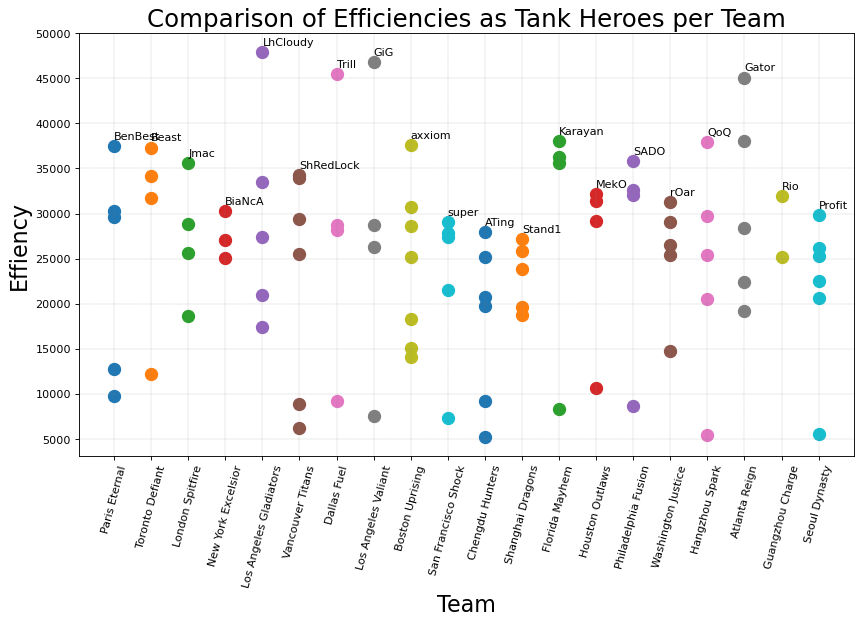

In [17]:
classes = [damagers, supports, tanks]
class_names = ["Damage", "Support", "Tank"]
for curr_class, class_name in zip(classes, class_names):
    # Take rows of only heroes of the current class
    curr_table = average_table.loc[average_table['hero_name'].isin(curr_class)].copy()

    # Define equations we will use to calculate overall efficiency and create efficiency column
    def healer_efficiency(row):
        if (class_name == "Damage"):
            return (2*row['Assists'] + 2*row['Barrier Damage Done'] - 1.5*row['Deaths'] + 2.5*row['Eliminations'] + 2*row['All Damage Done']
                    + 2*row['Final Blows'] + row['Healing Done'] + 2*row['Objective Kills'] + row['Objective Time'] + 1.5*row['Ultimates Earned'])
        elif (class_name == "Support"):
            return (2*row['Assists'] + 1.5*row['Barrier Damage Done'] - 2*row['Deaths'] + 2*row['Eliminations'] + row['All Damage Done']
                    + row['Final Blows'] + 2.5*row['Healing Done'] + 1.5*row['Objective Kills'] + 1.5*row['Objective Time'] + 1.5*row['Ultimates Earned'])
        else:
            return (1.5*row['Assists'] + row['Barrier Damage Done'] + 1.5*row['Damage Blocked'] - 3*row['Deaths'] + 2*row['Eliminations'] + row['All Damage Done']
                    + row['Final Blows'] + row['Healing Done'] + 1.5*row['Objective Kills'] + 1.5*row['Objective Time'] + row['Ultimates Earned'])
            
    curr_table['Efficiency'] = curr_table.apply(lambda row: healer_efficiency(row), axis=1)

    # Ignore rows with less than 5000 efficiency as that probably means the player only played as the healer for a short period of time
    # and drop newly irrelevant columns
    curr_table = curr_table[curr_table.Efficiency > 5000].groupby(['team_name', 'player_name']).mean().reset_index().sort_values('Efficiency', ascending=False)
    curr_table['Efficiency'] = curr_table['Efficiency'].round(decimals = 2)
    best_efficiency_table = curr_table.loc[curr_table.groupby('team_name')['Efficiency'].idxmax()].sort_values('Efficiency', ascending=False)

    # Plot efficiencies of each player for each team
    plots = plt.figure(figsize=(12.5,7), dpi=80).subplots()
    plt.grid(color = 'gray', linestyle = '--', linewidth = 0.2)
    for team in teams:
        plots.scatter(curr_table.loc[curr_table['team_name'] == team]['team_name'].tolist(), curr_table.loc[curr_table['team_name'] == team]['Efficiency'].tolist(), label=team, s=120)
    for index, row in  best_efficiency_table.iterrows():
        plots.annotate(row['player_name'], (row['team_name'], row['Efficiency']), xytext=(row['team_name'], row['Efficiency'] + 750))
    plots.set_xticklabels(teams, rotation=75)
    plots.set_xlabel('Team', fontsize=20)
    plots.set_ylabel('Effiency', fontsize=20)
    plots.set_yticks([5000,10000,15000,20000,25000,30000,35000,40000,45000,50000])
    plots.set_title('Comparison of Efficiencies as ' + class_name + ' Heroes per Team', fontsize=22)
    print("\nTop 3 most efficient " + class_name + " players: ")
    for index, row in curr_table.head(3).iterrows():
        print(row['player_name'] + " (" + row['team_name'] + "): " + str(row['Efficiency']))
    

These graphs allow us to easily see the most efficient players for each team on each class. Notably, we can see that one support player in particular stands out as the most efficienct support and damage hero for his team: Haksal. In fact, we could've seen this coming as Haksal, now retired, was regarded as one of the greatest Genji and Brigitte players of all time. His impact as a damage and support character gave New York Excelsior a huge upper hand against their opponents as the year before he had won the OWL's first Rookie of the Year award, and was named both an OWL Role Star and All-Star.

<H3>
    <Strong>
        Hero Picks by the Top 3 Players of each Class
    </Strong>
</H3>

For each class, we found that the most efficient three players are:  
<b>Damage</b>
1. Saucy (Atlanta Reign): 45351.24
2. zYKK (Toronto Defiant): 45013.08
3. Agilities (Toronto Defiant): 42955.2

<b>Support</b>  
1. Haksal (New York Excelsior): 50429.34
2. Boombox (Philadelphia Fusion): 50166.52
3. ir1s (Atlanta Reign): 49762.16

<b>Tank</b>
1. LhCloudy (Los Angeles Gladiators): 47879.26
2. GiG (Los Angeles Valiant): 46805.45
3. Trill (Dallas Fuel): 45493.45

Now, we can find the distribution of hero picks by each player i.e. what percent of in-game time they spend playing each hero.

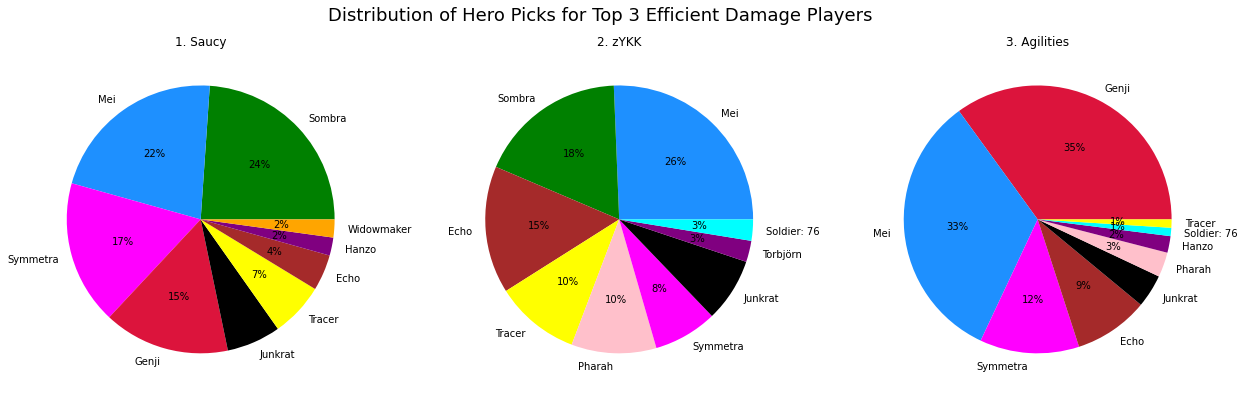

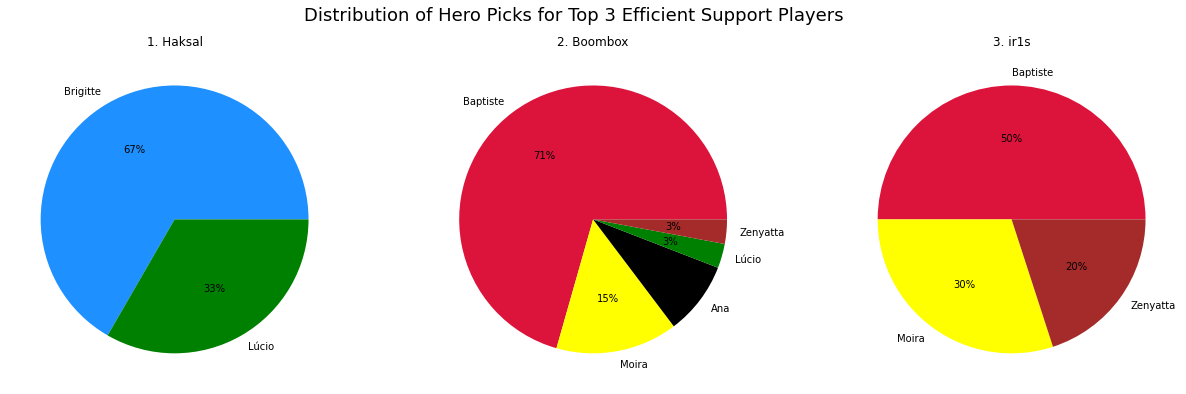

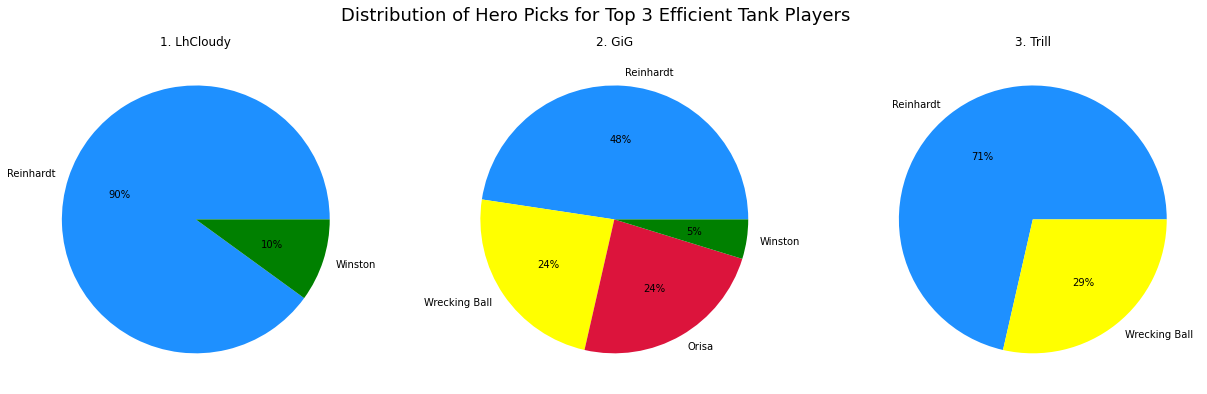

In [18]:
best_damagers = ['Saucy', 'zYKK', 'Agilities']
best_supports = ['Haksal', 'Boombox', 'ir1s']
best_tanks = ['LhCloudy', 'GiG', 'Trill']
best_classes = [best_damagers, best_supports, best_tanks]

colors={'Mei':'dodgerblue', 'Sombra':'green', 'Genji':'crimson', 'Tracer':'yellow', 'Junkrat':'black', 'Echo':'brown', 'Hanzo':'purple', 'Widowmaker':'orange', \
    'Pharah':'pink', 'Soldier: 76':'cyan', 'Brigitte':'dodgerblue', 'Lúcio':'green', 'Baptiste':'crimson', 'Moira':'yellow', 'Ana':'black', 'Zenyatta':'brown',\
        'Reinhardt':'dodgerblue', 'Winston':'green', 'Orisa':'crimson', 'Wrecking Ball':'yellow', 'Symmetra': 'magenta', 'Torbjörn': 'purple'}
for curr_class, curr_best, class_name in zip(classes, best_classes, class_names):
    # Plot pie chart for best damage players
    curr_table = data[['player_name', 'hero_name']]
    curr_table = curr_table.loc[curr_table['hero_name'].isin(curr_class)].copy()
    curr_table = curr_table.loc[curr_table['player_name'].isin(curr_best)]

    count = 1
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(21, 6.6))
    plt.subplots_adjust(wspace=.25)
    fig.suptitle("Distribution of Hero Picks for Top 3 Efficient " + class_name + " Players", fontsize=18, y=0.95)
    for player, ax in zip(curr_best, axs.ravel()):
        title = str(count) + '. ' + player
        curr_tab = curr_table.loc[curr_table['player_name'] == player]
        ax = curr_tab['hero_name'].value_counts().plot.pie(title=title, autopct='%1.0f%%', ax=ax, colors=[colors[v] for v in curr_tab['hero_name'].value_counts().keys()])
        ax.set_ylabel('')
        count += 1

<H3>
    <Strong>
        Win Percentage for Heroes
    </Strong>
</H3>

In this section, the win percentage of a hero on every map will be evaluated. Win percentage for a hero on a map is a very important statistics to evaluate when trying to build the optimal team composition for a map. Statistics are very important to look at but win percentage is the next best metric to determine the best overall composition of heroes.

In [19]:
#Filtering the multiple games that exist for a hero on every map
# then calculating the win percentages for that hero on that map
heroes, winners, maps = [], [], []
for map in map_list:
    for hero in hero_list:
        temp_hero = merged_df.loc[merged_df['hero_name'] == hero] 
        scores = temp_hero.loc[temp_hero['map_name'] == map]['winner']
        #To ensure no divide by zero error
        if (scores.size) == 0:
            winners.append(0)
        else:
            winners.append((sum(scores) / scores.size) * 100)
        heroes.append(hero)
        maps.append(map)
        #Made three arrays to store the map, hero, and win percentage to be 
        # added to a DataFrame
win_pct = pd.DataFrame()
win_pct['Hero'], win_pct['Map'], win_pct['Win_Pct']  = heroes, maps, winners
#Sorting by map then hero so the variables are in the same order as efficiency
#Helps later when combining tables
win_pct = win_pct.sort_values(by=['Map', 'Hero'], ascending = True).reset_index().drop('index', axis = 1)
win_pct.head(10)

,Hero,Map,Win_Pct
0,Ana,Blizzard World,50.000000
1,Ashe,Blizzard World,52.500000
2,Baptiste,Blizzard World,48.076923
3,Bastion,Blizzard World,0.000000
4,Brigitte,Blizzard World,47.058824
5,D.Va,Blizzard World,46.875000
6,Doomfist,Blizzard World,27.272727
7,Echo,Blizzard World,40.000000
8,Genji,Blizzard World,53.846154
9,Hanzo,Blizzard World,46.666667


Win percentage was evaluated versus wins to ensure that this was a fair metric to use for all heroes. Heroes are disproportionality chosen in the 2020 Overwatch League Season therefore it is important to ensure that the metric used can be standardized to low inputs or low pick rates. At first glance, the dataframe above shows a 0% win percentage for Bastion on the map Blizzard World. This means that a team that chose Bastion for Blizzard World never won a game in the 2020 Season of Overwatch League. However, Bastion is a hero that has a low pick rate this season and Bastion has not been a historically good pick on Blizzard World. Therefore, the low win percentage can be partially explained by low usage. Later, the win_pct DataFrame will be used in conjunction with efficiency to formulate a final team composition for every map. 

<H3>
    <Strong>
        Best Heroes From Each Class Based on Efficiency
    </Strong>
</H3>

Here efficiency will be calculated for every hero on every map. This will be done to eventually pair this metric with win percentage to create a final team composition for every map that esports teams should use in the future.

In [20]:
#Taking the average statistics for a hero in a match on a certain map and calculating the efficiency 
# based on the previous efficiency equation. Will end with a dataframe of the efficiency of every 
# hero on every map
average_table = data
average_table = average_table.groupby(['match_id', 'map_name', 'hero_name']).mean().reset_index()
classes = [damagers, supports, tanks]
class_names = ["Damage", "Support", "Tank"]
efficiency_df = pd.DataFrame()
#Ensuring that the efficiency function is applied on a class basis
for curr_class, class_name in zip(classes, class_names):
    #Take rows of only heroes of the current class
    curr_table = average_table.loc[average_table['hero_name'].isin(curr_class)].copy()
    #Define equations we will use to calculate overall efficiency and create efficiency column
    curr_table['Efficiency'] = curr_table.apply(lambda row: healer_efficiency(row), axis=1)
    heroes, effic, maps = [], [], []
    #Averaging out efficiency for a hero on a specific map
    for map in map_list:
        for hero in curr_class:
            temp_hero = curr_table.loc[curr_table['hero_name'] == hero] 
            scores = temp_hero.loc[temp_hero['map_name'] == map]['Efficiency']
            #To prevent divide by zero
            if (scores.size) == 0:
                effic.append(0)
            else:
                effic.append(scores.mean())
            heroes.append(hero)
            maps.append(map)
    temp_effic = pd.DataFrame()
    temp_effic['Hero'], temp_effic['Map'], temp_effic['Efficiency']  = heroes, maps, effic
    temp_effic['Efficiency'] = temp_effic['Efficiency'].round(decimals = 2)
    efficiency_df = pd.concat([efficiency_df, temp_effic])
#Sorting by map then hero so the variables are in the same order as win percentage
#Helps later when combining tables
efficiency_df = efficiency_df.sort_values(by=['Map', 'Hero'], ascending = True).reset_index().drop('index', axis = 1)
efficiency_df

,Hero,Map,Efficiency
0,Ana,Blizzard World,29934.71
1,Ashe,Blizzard World,46052.00
2,Baptiste,Blizzard World,46599.13
3,Bastion,Blizzard World,0.00
4,Brigitte,Blizzard World,30763.00
...,...,...,...
667,Widowmaker,Watchpoint: Gibraltar,10728.65
668,Winston,Watchpoint: Gibraltar,33330.12
669,Wrecking Ball,Watchpoint: Gibraltar,1429.73
670,Zarya,Watchpoint: Gibraltar,24369.88


The efficiency equation that was used previously in player efficiency will also be used here to calculate the efficiency of every hero on every map. The same equation is used for the same reasons stated previously. The equation was created to gain an overall efficiency for a hero to better understand the various statistics and the overall efficiency of a hero. It also is worth pointing out that as can be seen in the efficiency_df DataFrame that Bastion on Blizzard World has an efficiency of 0. This is similar to what was discussed in the previous win percentage section. Bastion was rarely used or was never used on Blizzard World. This will explain the extremely low efficiency numbers for almost all heroes on a specific map.

### Best Team Composition for Every Map Based on Efficiency

A dataset that was tidier will be more favorable for analysis moving forard. Therefore, we created a similar DataFrame as win_pct to aid future analysis. We also want to look to see how the most efficient players on a map compare to the final composition of heroes for a map. So, in this section, we will evaluate the best two heroes per hero class per map.

In [21]:
hero_class, classes = [], ['Damage','Support', 'Tank']
#Appending class name to win percentage and efficiency dataframe
for index,row in efficiency_df.iterrows():
    if row['Hero'] in damagers:
        hero_class.append('Damage')
    if row['Hero'] in tanks:
        hero_class.append('Tank')
    if row['Hero'] in supports:
        hero_class.append('Support')
win_pct['Class'] = hero_class
efficiency_df['Class'] = hero_class
top_two_df = pd.DataFrame()
#Finding top two heroes per class per map based on efficiency score
for map in map_list:
    temp_df = efficiency_df.loc[efficiency_df['Map'] == map]
    for class_type in classes:
        #Filtering by map then class
        temp_df = efficiency_df.loc[efficiency_df['Map'] == map]
        temp_df = temp_df.loc[temp_df['Class'] == class_type]
        temp_df = temp_df.sort_values(by=['Efficiency'], ascending=False).head(2)
        combine = [top_two_df, temp_df]
        top_two_df = pd.concat(combine)
top_two_df.head(10)

,Hero,Map,Efficiency,Class
104,Genji,Eichenwalde,47304.94,Damage
121,Torbjörn,Eichenwalde,45409.87,Damage
98,Baptiste,Eichenwalde,39182.04,Support
111,Moira,Eichenwalde,32202.11,Support
112,Orisa,Eichenwalde,49695.77,Tank
115,Reinhardt,Eichenwalde,45473.04,Tank
167,Echo,Havana,62722.79,Damage
173,Mei,Havana,54904.05,Damage
191,Zenyatta,Havana,35494.89,Support
175,Moira,Havana,31920.29,Support


This top_two_df Dataframe is very hard to read and analyze. Therefore, we will make a tidier DataFrame now with all of the two most efficient hero picks for every map. 

In [22]:
#Putting our results from the previous cell into dataframe form
#Will show the best team composition of heroes for every map based on efficiency
team_comp_effic_df = pd.DataFrame(columns = ['Map', 'Damage #1', 'Damage #2', 'Support #1', 'Support #2', 'Tank #1', 'Tank #2'])
for map in map_list:
    map_top_two = top_two_df.loc[top_two_df['Map'] == map]
    #Only need index 0 because only need map name once for display
    comp_array = np.array(map_top_two['Map'])[0]
    comp_array = np.append(comp_array, np.array(map_top_two['Hero']))
    #converting to a series to ensure it can be appended to a dataframe
    comp_series = pd.Series(comp_array, index = team_comp_effic_df.columns)
    team_comp_effic_df = team_comp_effic_df.append(comp_series, ignore_index=True)
team_comp_effic_df =  team_comp_effic_df[['Map','Damage #1','Damage #2','Tank #1','Tank #2','Support #1','Support #2']]
team_comp_effic_df

,Map,Damage #1,Damage #2,Tank #1,Tank #2,Support #1,Support #2
0,Eichenwalde,Genji,Torbjörn,Orisa,Reinhardt,Baptiste,Moira
1,Havana,Echo,Mei,Orisa,Sigma,Zenyatta,Moira
2,Horizon Lunar Colony,McCree,Junkrat,Reinhardt,D.Va,Ana,Zenyatta
3,Lijiang Tower,Mei,Pharah,Reinhardt,Orisa,Baptiste,Moira
4,Junkertown,Torbjörn,Echo,Orisa,Sigma,Baptiste,Zenyatta
5,Kings Row,Mei,Echo,Orisa,Sigma,Baptiste,Moira
6,Dorado,Torbjörn,Pharah,Reinhardt,Orisa,Ana,Moira
7,Hanamura,Mei,Genji,Sigma,Orisa,Baptiste,Brigitte
8,Nepal,Mei,Pharah,Reinhardt,Sigma,Baptiste,Moira
9,Blizzard World,Echo,Mei,Sigma,Orisa,Baptiste,Zenyatta


The team composition for every map is now displayed in the DataFrame table above based on average efficiency. We decided to take the two top most efficient heroes for every class on every map because in this season of Overwatch League teams were restricted to choose two damage characters, two tank characters, and two support characters. There is also a distinction between whether a character was the #1 or #2 most efficient. This denotes who the main damage character, main tank character, and main support character. There is similarly a term called off-tank, off-support, and off-damage. These describe who should be the primary player for the team's role or the secondary option. In terms of support, the main support will be much more fixated on healing tanks and heroes in the main fight whereas off-support is focused characters in side fights or performing a different role. This makes a lot of sense for characters like Moira and Baptiste who were predominately in the main support role. Moira and Baptiste are commonly chosen as the main support because they are the heroes with some of the highest healing output. The tank choice also makes sense why Orisa was typically the main tank chosen and sigma was the off-tank. Orisa's abilities (or game functions) are centered around playing in a main collective fight and not being very mobile. Whereas Sigma, has a lot of mobility and has functions that allow him to play better in siden fights. The distinction between main damage and off-damage isn't very impactful in this season of Overwatch because main damage just has a slight increase in damage output on average. This is why heroes, like Mei and Echo, are typically not limited to one role and appear in both roles. Comparing these compositions to the hero pick rates of the most efficient esports players we see some similarities and also some differences. In terms of damage heroes, the pick rates by professional players lines up with the team compositions based on efficiency. Mei was picked the most by all three most efficient esports players and showed up the most in our efficiency DataFrame table. Genji was another hero that was picked very frequently by Agilities and Saucy and was one of the most common damage players in terms of efficiency per map. Our data does vary quite drastically in terms of Tanks. Reinhardt was easily the most chosen tanks by the three most efficient tank esports players. However, he only appeared 5 times in our DataFrame table. It is worth noting that Orisa was played a good amount by the player GiG and appeared in our DataFrame table the most. Support heroes matched up fairly well against the most efficient support esports players. Baptiste was heavily played by the players Boombox and irls anmd he occurred in our DataFrame the most of any other support player. Brigitte was played by Haksal a very large amount of time and appeared in our top three to four for support hero that appeared in the most team compositions. Overall, our statistics regarding efficiently matched up well the professional esports players opinions and hero pick rates.

<H3>
    <Strong>
        Final Team Composition Creation for Every Map
    </Strong>
</H3>

This section will be the culmination of our final project as we look to see the best composition of Overwatch heroes for every match. First, we need a variable that can be used to compare every hero on every map. We decided to make a new variable called Master Key to be used in comparisons to find the best compostion of heroes.
* Master Key = 2(Efficiency / mean(Efficiency)) + (win_percent / mean(win_percent))

### Master Key Variable Creation

In [23]:
#Creates 'Master Key' which will be the variable used in final team composition creation
win_pct['Efficiency'] = efficiency_df['Efficiency']
#Equation is 2*(Efficiency / mean(Efficiency)) + win_Percent / mean(win_Percent)
win_pct['Master Key'] = (2*win_pct['Efficiency'] / (win_pct['Efficiency'].mean())) + (win_pct['Win_Pct'] / (win_pct['Win_Pct'].mean()))
win_pct = win_pct[['Hero','Map','Class','Win_Pct','Efficiency','Master Key']]
win_pct.sort_values(by=['Master Key'], ascending = False).reset_index().drop('index', axis = 1)

,Hero,Map,Class,Win_Pct,Efficiency,Master Key
0,Genji,Rialto,Damage,71.428571,70527.17,8.663480
1,Mei,Kings Row,Damage,54.430380,68206.68,8.057250
2,Orisa,Rialto,Tank,50.000000,61534.31,7.288653
3,Echo,Havana,Damage,33.333333,62722.79,7.042807
4,Sigma,Blizzard World,Tank,50.000000,58623.79,6.995762
...,...,...,...,...,...,...
667,Echo,Horizon Lunar Colony,Damage,0.000000,0.00,0.000000
668,Bastion,Paris,Damage,0.000000,0.00,0.000000
669,Bastion,Junkertown,Damage,0.000000,0.00,0.000000
670,Junkrat,Junkertown,Damage,0.000000,0.00,0.000000


The equation for Master Key was formulated to give efficiency 2 times the weight of win percentage. This way efficiency made up two thirds of Master Key. We felt it was important to trust the efficiency statistic much more than the average win percentage when trying to determine the best hero composition. It is possible for a hero to not be as impactful but still get a win because they team they are playing is much worse. We feel it is less likely if a hero doesn't play well (low efficiency) that their team will still win. We specifically chose two times greater to give efficiency a mide majority over win percentage because we feel it is a much more accurate measuere. Also, after comparing the hero pick rates of professional players to our best team compositions in regards to efficiency, we felt that efficiency was a very strong statistic to use to find a final team composition. It is worth noting here that Genji on Rialto was the best fitting hero for a map. This makes sense because it is a very wide spread map with varios hiding spots and corners. Genji can play very well on a map like this because his abilities are very suited for the terrain and layout of the map. We see a few heroes on certain maps have a Master Key value of 0. This is because some heroes are not played certain maps because they aren't as favorable on that map. Bastion for example is not played on Paris or Junkertown because they are wide open maps with not a lot of coverage and Bastion relies heavily on map coverage and more dense map layouts.

In [24]:
#Creates an array for each class
damage_df = win_pct.loc[win_pct['Class'] == 'Damage'].sort_values(by=['Master Key'], ascending=False)
support_df = win_pct.loc[win_pct['Class'] == 'Support'].sort_values(by=['Master Key'], ascending=False)
tank_df = win_pct.loc[win_pct['Class'] == 'Tank'].sort_values(by=['Master Key'], ascending=False)
maps,damage_one,damage_two,support_one,support_two,tank_one,tank_two  = [],[],[],[],[],[],[]
#Team composition is based on individual map therefore 
# looping through all the maps
for map in map_list:
    best_damage = damage_df.loc[damage_df['Map'] == map].head(2)
    best_damage_arr = np.array(best_damage['Hero'])
    #Adding best two from every class for a map to arrays to be added to dataframe later
    damage_one.append(best_damage_arr[0])
    damage_two.append(best_damage_arr[1])
    best_support = support_df.loc[support_df['Map'] == map].head(2)
    best_support_arr = np.array(best_support['Hero'])
    support_one.append(best_support_arr[0])
    support_two.append(best_support_arr[1])
    best_tank = tank_df.loc[tank_df['Map'] == map].head(2)
    best_tank_arr = np.array(best_tank['Hero'])
    tank_one.append(best_tank_arr[0])
    tank_two.append(best_tank_arr[1])
    maps.append(map)
#Creates DataFrame to visually see final team composition results
final_team_composition = pd.DataFrame()
final_team_composition['Map'],final_team_composition['Damage #1'] = maps, damage_one, 
final_team_composition['Damage #2'],final_team_composition['Tank #1']= damage_two, tank_one
final_team_composition['Tank #2'], final_team_composition['Support #1'], final_team_composition['Support #2'] =  tank_two, support_one, support_two
final_team_composition

,Map,Damage #1,Damage #2,Tank #1,Tank #2,Support #1,Support #2
0,Eichenwalde,Genji,Torbjörn,Orisa,Reinhardt,Baptiste,Ana
1,Havana,Echo,Mei,Orisa,Sigma,Zenyatta,Moira
2,Horizon Lunar Colony,Junkrat,Pharah,Reinhardt,D.Va,Ana,Zenyatta
3,Lijiang Tower,Mei,Pharah,Reinhardt,Orisa,Baptiste,Moira
4,Junkertown,Torbjörn,Echo,Orisa,Zarya,Baptiste,Zenyatta
5,Kings Row,Mei,Echo,Orisa,Sigma,Baptiste,Brigitte
6,Dorado,Torbjörn,Pharah,Reinhardt,Orisa,Ana,Brigitte
7,Hanamura,Mei,Genji,Sigma,Orisa,Baptiste,Brigitte
8,Nepal,Mei,Pharah,Roadhog,Reinhardt,Baptiste,Moira
9,Blizzard World,Echo,Mei,Sigma,Orisa,Baptiste,Zenyatta


This is the finalized hero composition for every map. It seems to be that Orisa and Sigma are predominately favorable on most maps. A map where neither hero is favorable is Watchpoint: Gibraltar, which makes sense because this map is very open with a lot of coverage. Tanks like Winston and D.Va which rely on their mobility to attack teams floruish on this map. In terms of support, heroes like Baptiste and Brigitte are the most common healers across maps. Mei and Echo or Genji are the most common damage heroes across the maps with some heroes like Torbjörn and Pharah being favorable on a few maps. I would like to point out that for the map Rialto all the favorable heroes make a lot of sense when thinking about the layout of the map. Rialto has a lot of close corners and hiding sports where heroes like Mei and Genji will perform very well. This is also a map where the objective (a truck or payload is moved a certain distance) is great for tanks like Orisa and Sigma. Both of these heroes have functions where their Shields can be moved to protect teammates which is very strong on maps where the objective is constantly moving. Baptise and Zenyatta on this map are also very favorable because they each have an ability that renders one of Genji's abilities useless and is a great counter attack against Genji. Pharah is also favorable on Ilios which can be explained by the fact that Pharah has an ability to knock players backward and Ilio is a map with a lot of close edges and places where an enemy can be knocked off an edge and die. We had planned to run this code with an inner for loop that iterated over the various classes to remove redundant code. However, when we added this for loop and if statements in the lines of code was actually longer than if we did it brute force.

<div align="center">
    <H1>
        <Strong>
            Conclusion and Further Analysis
        </Strong>
    </H1>
</div>

The objective of this project was to find an optimal team composition for every map based on the relevant statistics and overall average win percentage. We have completed this and it is now time to compare these team compositions to the pick rates of the three most efficient esports players at every hero class. We are making this comparison to see if the team compositions in the 2020 Overwatch League Season was back up by the statistics. Looking at Tanks, we see that the most common tank picked by far was Reinhardt. Our data did not suggest that Reinhardt was a major contributor on most maps and he only appeared in the top two tank efficiencies 6 times. This can somewhat be explained by the fact that the maps that he was chosen to be in the optimal team composition for are some of the most popular and common maps played in the 2020 Overwatch League Season. Maps like Lijiang Tower, Eichenwalde, amd Nepal are usually played in every game series. However, our data did not suggest that Wrecking Ball was an optimal hero to be included in hero compositions and he was the second most picked hero for the three most efficient players this season. This can somewhat be explained by the nature of the Wrecking Ball hero. Wrecking Ball's main objective is to disrupt and play in a very niche role. Therefore, his impact may not be directly correlated to his pure statistics. He also is a character that relies on Environmental Kills and other less important statistics that we felt wasnm't important to look at when evaluating all 32 heroes. The support hero pick rates largely coincide with our final optimal team compositions where heroes like Baptiste and Zenyatta were picked very often and they were two of the most common among all the map's team compositions. The one suprising point would be that Lucio was not in any of our optimal team compositions yet is one of the top three most picked healers for some professional players. However, like Wrecking Ball this can be explained by his unique abilits that makes his imapct not directly relate to his statistics. One of his main roles is to give a speed boost to teammates (offensive assists) as well as get environment kills by using his abilities. Neither offensive assists nor environmental kills were included in our analysis because they are not very imapctful for all 32 heroes only a few of them. It is also worth menttioning that we did not take hero pairings into account when performing our data analysis. Heroes like Phara and Mercy are almost always played together. You will rarely find a time whrere Phara is played and Mercy isn't. This is important to note but we still believe that our Master Key variable is a good metric to find the best team composition. 

The data that we looked at was only a small portion of the data available on the Overwatch League website. We only looked at 2020 Regular Season data and we only evaluated a few of the statistics that we felt was important. We also only looked at Overwatch League statistics on PC and not on any other console. In the future, it may be interesting to compare some of the more niche statistics to see if we can get a better sense of the data and it's heroes. In newer seasons of Overwatch League, there were hero bans as well as different hero changes which could contribute to use finding a completely different hero composition if we ran our analysis on a different Overwatch League Season. This analysis can also be used in the future to advise professional Overwatch teams that struggled during the previous season. If the current methodology isn't working for an esports team, we recommend utilizing our team compositions and data to try and improve their team.